In [8]:
data_dir = "dataset/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [9]:
import os
filenames = [filename for filename in os.listdir(data_dir)]
filenames

['dev.txt', 'test.txt', 'train.txt']

In [10]:
def get_lines(filename):
    with open(filename,"r") as f:
        return f.readlines()

In [11]:
train_lines = get_lines(data_dir+"train.txt")

Preprocess Data

In [17]:
def preprocess_text(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []
    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()


            for abstract_lines_number , abstract_line in enumerate(abstract_line_split):
                line_data ={}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_lines_number
                line_data["total_line"] = len(abstract_line_split) -1
                abstract_samples.append(line_data)
        else:
            abstract_lines+= line

    return abstract_samples

In [25]:
train_samples = preprocess_text(data_dir+"train.txt")
val_samples = preprocess_text(data_dir+"dev.txt")
test_samples = preprocess_text(data_dir+"test.txt")


In [27]:
test_samples[11]

{'target': 'METHODS',
 'text': 'resource use was determined from the amsterdam acute aneurysm ( ajax ) trial , a multicentre randomized trial comparing evar with or in patients with raaa .',
 'line_number': 2,
 'total_line': 12}

In [30]:
len(test_samples)

30135

In [31]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)


In [33]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

In [34]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()


In [40]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)
train_labels_one_hot = ohe.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = ohe.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = ohe.transform(test_df["target"].to_numpy().reshape(-1, 1))


In [39]:
import tensorflow as tf

In [42]:
tf.constant(test_labels_one_hot)

<tf.Tensor: shape=(30135, 5), dtype=float64, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])>

In [43]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = le.transform(val_df["target"].to_numpy())
test_labels_encoded = le.transform(test_df["target"].to_numpy())

In [45]:
num_classes = len(le.classes_)
class_names = le.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [48]:
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [49]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [46]:
from helper_functions import calculate_results

In [50]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [51]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [52]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

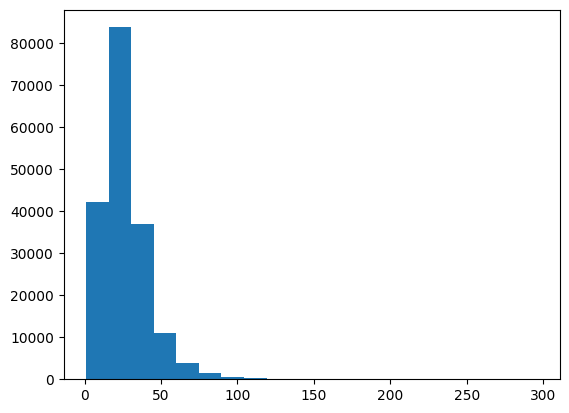

In [55]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);